In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
sale_data = pd.read_csv('data/m5-forecasting-accuracy/sales_train_validation.csv')
day_data = sale_data[[f'd_{day}' for day in range(1,1914)]]
total_sum = np.sum(day_data,axis=0).values

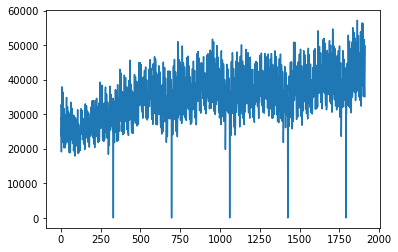

In [4]:
plt.plot(total_sum)

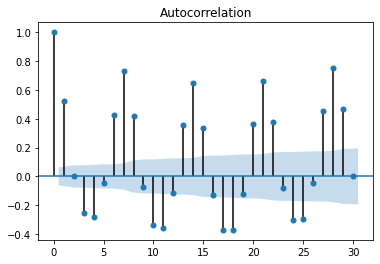

In [5]:
# 自相关性
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(total_sum[-1000:]);

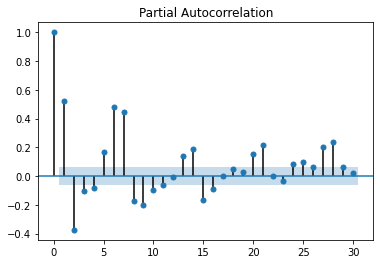

In [6]:
# 偏自相关性
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(total_sum[-1000:]);

In [7]:
# 单位根检验
from statsmodels.stats.diagnostic import unitroot_adf
print('P_value:{}'.format(unitroot_adf(total_sum[-200:])[1]))

P_value:0.7004939205242363


/Users/fatu/venv/kaggle/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:62: FutureWarning: unitroot_adf is deprecated and will be removed after 0.11.
  FutureWarning)


In [8]:
# 做差分
# 再做单位根检验
print('P_value:{}'.format(unitroot_adf(np.diff(total_sum[-200:]))[1]))

P_value:7.777309805571406e-07


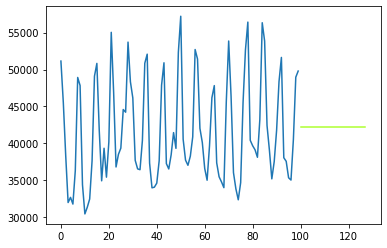

In [9]:
# 均值预测
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+[total_sum[-28:].sum()/len(total_sum[-28:])]*28,color='greenyellow')

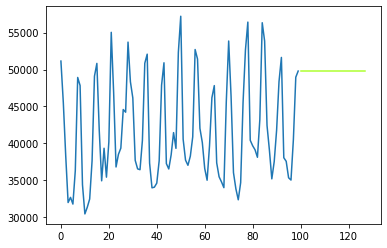

In [10]:
# 朴素预测
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+[total_sum[-1]]*28,color='greenyellow')

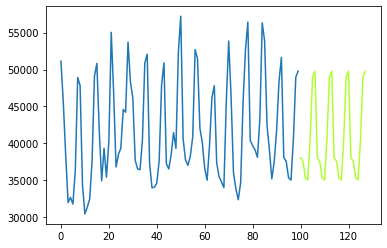

In [11]:
# 季节性朴素预测法
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+[total_sum[-i] for i in range(7,0,-1)]*4,color='greenyellow')

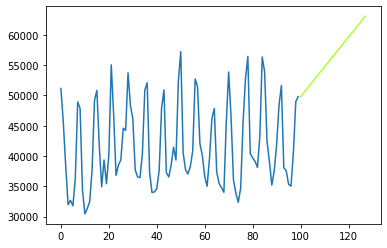

In [12]:
# 飘移动法
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+[total_sum[-1]+i*(total_sum[-1]-total_sum[-28])/28 for i in range(28)],color='greenyellow')

In [13]:
# 移动平均
total_ts = pd.Series(total_sum)
moving_mean = total_ts.rolling(window=5).mean()
for i in range(10):
    moving_mean = moving_mean.rolling(window=5).mean()

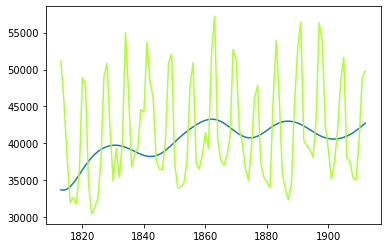

In [14]:
# 画趋势图
plt.plot(moving_mean[-100:])
plt.plot(total_ts[-100:],color='greenyellow')

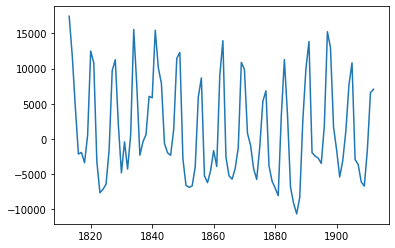

In [15]:
# 减去趋势项，看周期项
plt.plot(total_ts[-100:] - moving_mean)

In [16]:
# STL时序分解算法
import statsmodels.api as sm
rd = sm.tsa.seasonal_decompose(total_sum[-300:], freq=7)

/Users/fatu/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


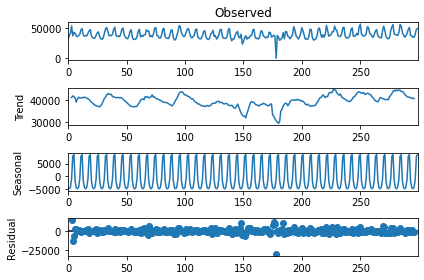

In [17]:
rd.plot();

In [18]:
# 计算趋势性强度
FT = max(0,1-np.std(rd.resid[~np.isnan(rd.resid)])/np.std(tmp[~np.isnan(tmp)]))
print(FT)

NameError: name 'tmp' is not defined

In [19]:
# 一阶指数平滑模型
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
alpha = 0.15
simpleExpSmooth_model = SimpleExpSmoothing(total_sum[-10:]).fit(smoothing_level=alpha,optimized=False)

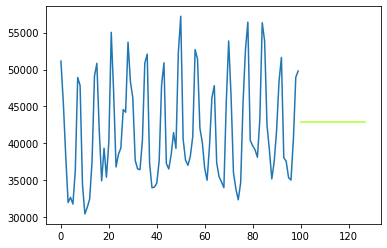

In [20]:
simpleExpSmooth_model.forecast(28)
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+simpleExpSmooth_model.forecast(28).tolist(),color='greenyellow')

In [21]:
# 二阶指数平滑模型
from statsmodels.tsa.holtwinters import Holt
DaMExpSmooth_model = Holt(total_sum[-120:], damped=True).fit(smoothing_level=0.9, smoothing_slope=0.8)

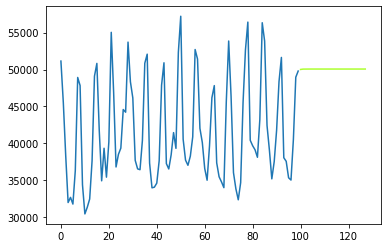

In [22]:
DaMExpSmooth_model.forecast(28)
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+DaMExpSmooth_model.forecast(28).tolist(),color='greenyellow')

In [23]:
# 三阶指数平滑模型
from statsmodels.tsa.holtwinters import ExponentialSmoothing
HW_ExpSmooth_model = ExponentialSmoothing(total_sum[-120:], seasonal_periods=7, trend='add', seasonal='add', damped=True).fit()

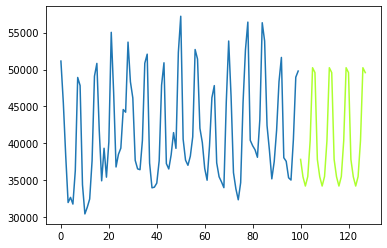

In [24]:
HW_ExpSmooth_model.forecast(28)
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+HW_ExpSmooth_model.forecast(28).tolist(),color='greenyellow')

In [28]:
# ARIMA 模型
# 使用 auto_arima 包
from pmdarima import auto_arima
arima_model = auto_arima(total_sum[-120:], start_p=0, start_q=0,
                          max_p=10, max_q=5,
                          seasonal=False,
                          d=None, trace=True,random_state=666,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
arima_model.summary() 

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2442.797, BIC=2448.355, Time=0.041 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2443.892, BIC=2452.230, Time=0.016 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2443.178, BIC=2451.516, Time=0.017 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2440.838, BIC=2443.617, Time=0.005 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=2426.822, BIC=2437.938, Time=0.099 seconds
Near non-invertible roots for order (1, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Total fit time: 0.193 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1209.411
Date:                Sat, 02 May 2020   AIC                           2426.822
Time:                        19:24:34   BIC                           2437.938
Sample:                             0   HQIC                          2431.336
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.1437     24.287      1.406      0.160     -13.458      81.745
ar.L1          0.5739      0.135      4.249      0.000       0.309       0.839
ma.L1         -0.9928      0.155     -6.388      0.000      -1.297      -0.688
sigma2      4.597e+07   1.72e-05   2.68e+12      0.000     4.6e+07     4.6e+07
===================================================================================
Ljung-Box (Q):                      536.02   Jarque-Bera (JB):                 4.17
Prob(Q):                              0.00   Prob(JB):                         0.12
Heteroskedasticity (H):               0.86   Skew:                             0.43
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+28. Standard errors may be unstable.
"""

In [29]:
arima_model.fit(total_sum[-100:])

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

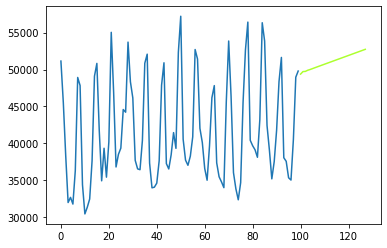

In [30]:
arima_model.predict(n_periods=28)
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+arima_model.predict(n_periods=28).tolist(),color='greenyellow')

In [31]:
# SARIMA 模型
# 使用 auto_arima 包
from pmdarima import auto_arima
sarima_model = auto_arima(total_sum[-120:], start_p=0, start_q=0,
                          max_p=10, max_q=5,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=666,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(1,0,1,7) [intercept=True]; AIC=2368.452, BIC=2379.568, Time=0.213 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=True]; AIC=2442.797, BIC=2448.355, Time=0.008 seconds
Fit ARIMA(1,1,0)x(1,0,0,7) [intercept=True]; AIC=2363.516, BIC=2374.633, Time=0.126 seconds
Fit ARIMA(0,1,1)x(0,0,1,7) [intercept=True]; AIC=2411.174, BIC=2422.291, Time=0.036 seconds
Fit ARIMA(0,1,0)x(0,0,0,7) [intercept=False]; AIC=2440.838, BIC=2443.617, Time=0.006 seconds
Fit ARIMA(1,1,0)x(0,0,0,7) [intercept=True]; AIC=2443.892, BIC=2452.230, Time=0.014 seconds
Fit ARIMA(1,1,0)x(2,0,0,7) [intercept=True]; AIC=2357.022, BIC=2370.917, Time=0.232 seconds
Fit ARIMA(1,1,0)x(2,0,1,7) [intercept=True]; AIC=2363.010, BIC=2379.684, Time=0.492 seconds
Fit ARIMA(1,1,0)x(1,0,1,7) [intercept=True]; AIC=2365.906, BIC=2379.801, Time=0.274 seconds
Fit ARIMA(0,1,0)x(2,0,0,7) [intercept=True]; AIC=2356.876, BIC=2367.992, Time=0.231 seconds
Fit ARIMA(0,1,0)x(1,0,0,7) [intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 7)   Log Likelihood               -1173.267
Date:                            Sat, 02 May 2020   AIC                           2356.534
Time:                                    19:24:41   BIC                           2370.430
Sample:                                         0   HQIC                          2362.177
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -75.5494    303.988     -0.249      0.804    -671.355     520.256
ma.L1         -0.1588      0.072     -2.214      0.027      -0.299      -0.018
ar.S.L7        0.4339      0.032     13.764      0.000       0.372       0.496
ar.S.L14       0.2831      0.043      6.621      0.000       0.199       0.367
sigma2      2.041e+07      0.005   3.84e+09      0.000    2.04e+07    2.04e+07
===================================================================================
Ljung-Box (Q):                       69.85   Jarque-Bera (JB):                19.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.96e+24. Standard errors may be unstable.
"""

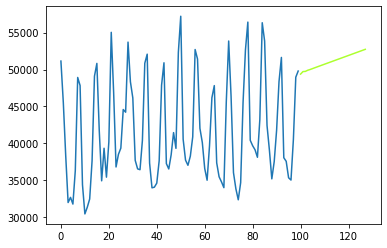

In [32]:
arima_model.predict(n_periods=28)
plt.clf()
plt.plot(total_sum[-100:])
plt.plot([np.nan]*100+arima_model.predict(n_periods=28).tolist(),color='greenyellow')